In [1]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Load pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

c:\vs code\vs programs\AI assignment\imagesegenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\vs code\vs programs\AI assignment\imagesegenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [2]:
def segment_image(image_path):
    image = Image.open(image_path)
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        predictions = model(image_tensor)
    return image, predictions


In [3]:
def visualize_segments(image, predictions, threshold=0.5):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    for i, mask in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = mask[0, :, :].mul(255).byte().cpu().numpy()
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                polygon = plt.Polygon(contour.reshape(-1, 2), fill=True, edgecolor='r', linewidth=2, alpha=0.3)
                ax.add_patch(polygon)
    plt.show()

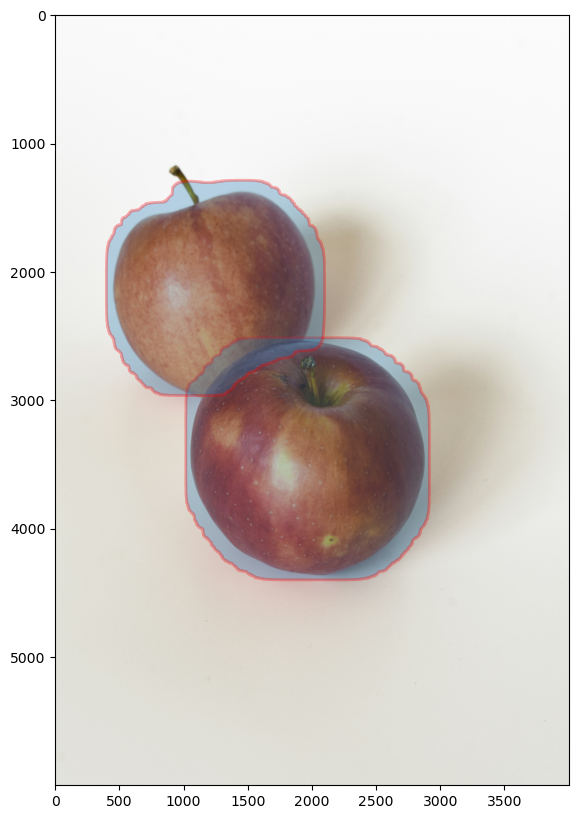

In [4]:
image, predictions = segment_image('apple.jpg')
visualize_segments(image, predictions)

In [5]:
import numpy as np
import os

def extract_objects(image, predictions, output_dir='output_objects', threshold=0.5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    master_id = 'image_001'  # Example master ID
    object_metadata = []
    for i, mask in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = mask[0, :, :].mul(255).byte().cpu().numpy()
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                object_image = np.array(image)[y:y+h, x:x+w]
                object_id = f'{master_id}_obj_{i+1}'
                object_metadata.append({'master_id': master_id, 'object_id': object_id})
                cv2.imwrite(os.path.join(output_dir, f'{object_id}.png'), object_image)
    return object_metadata


In [6]:
metadata = extract_objects(image, predictions)
print(metadata)

[{'master_id': 'image_001', 'object_id': 'image_001_obj_1'}, {'master_id': 'image_001', 'object_id': 'image_001_obj_2'}]


In [7]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

c:\vs code\vs programs\AI assignment\imagesegenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def identify_object(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    return probs

In [9]:
output_dir = 'output_objects'
for obj in metadata:
    obj_image_path = os.path.join(output_dir, f"{obj['object_id']}.png")
    description = identify_object(obj_image_path)
    obj['description'] = description
    print(f"Object ID: {obj['object_id']}, Description: {description}")

ValueError: You have to specify input_ids